In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# model libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score


In [2]:
# Importando el dataset
df = pd.read_csv('dataset.csv')


# Preprosesamiento de datos

## Limpieza

In [3]:
# Convertir todo a minusculas
df = df.apply(lambda x: x.astype(str).str.lower())

In [4]:
# Eliminar columna id
df = df.drop(['id'], axis=1)

In [5]:
from string import punctuation
# Eliminar signos de puntuacion
df['text'] = df['text'].apply(lambda x: ''.join([i for i in x if i not in punctuation]))
# Remove @
df['text'] = df['text'].str.replace('@', '')

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
# Remove stop words
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

## Explorando Datos

Frecuencia de palabras en tweets que representan desastres

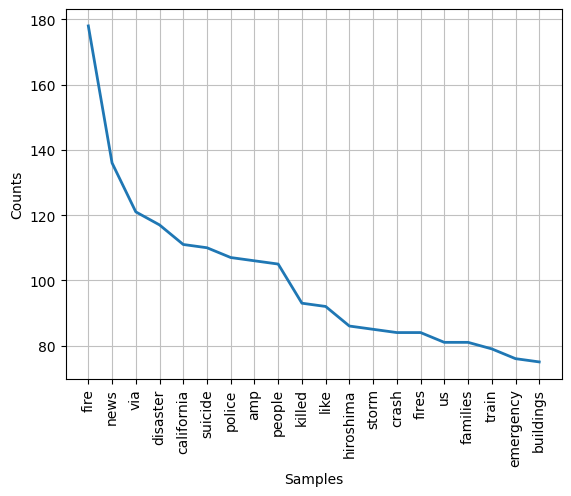

<Axes: xlabel='Samples', ylabel='Counts'>

In [7]:
disasters = df[df['target'] == '1']['text']
non_disasters = df[df['target'] == '0']['text']
disaster_words = [w for sentence in disasters for w in sentence.split()]
non_disaster_words = [w for sentence in non_disasters for w in sentence.split()]

# Plot
nlp_words=nltk.FreqDist(disaster_words)
nlp_words.plot(20)


Frecuencia de palabras en tweets que no representan desastres

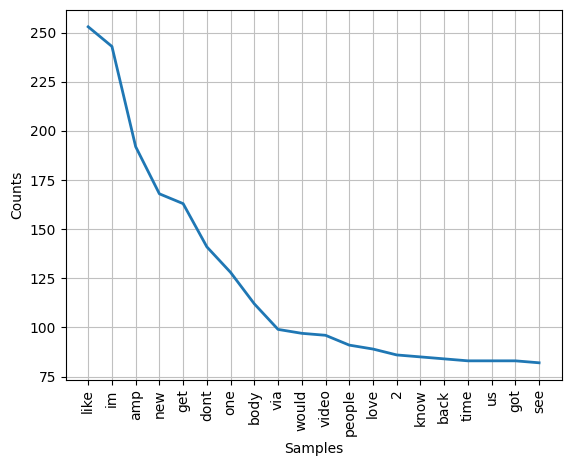

<Axes: xlabel='Samples', ylabel='Counts'>

In [8]:
nlp_words=nltk.FreqDist(non_disaster_words)
nlp_words.plot(20)

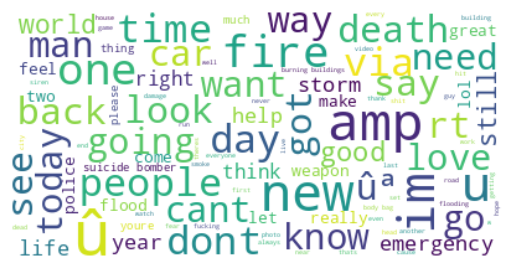

In [9]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(word for word in df['text'])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Unigrama

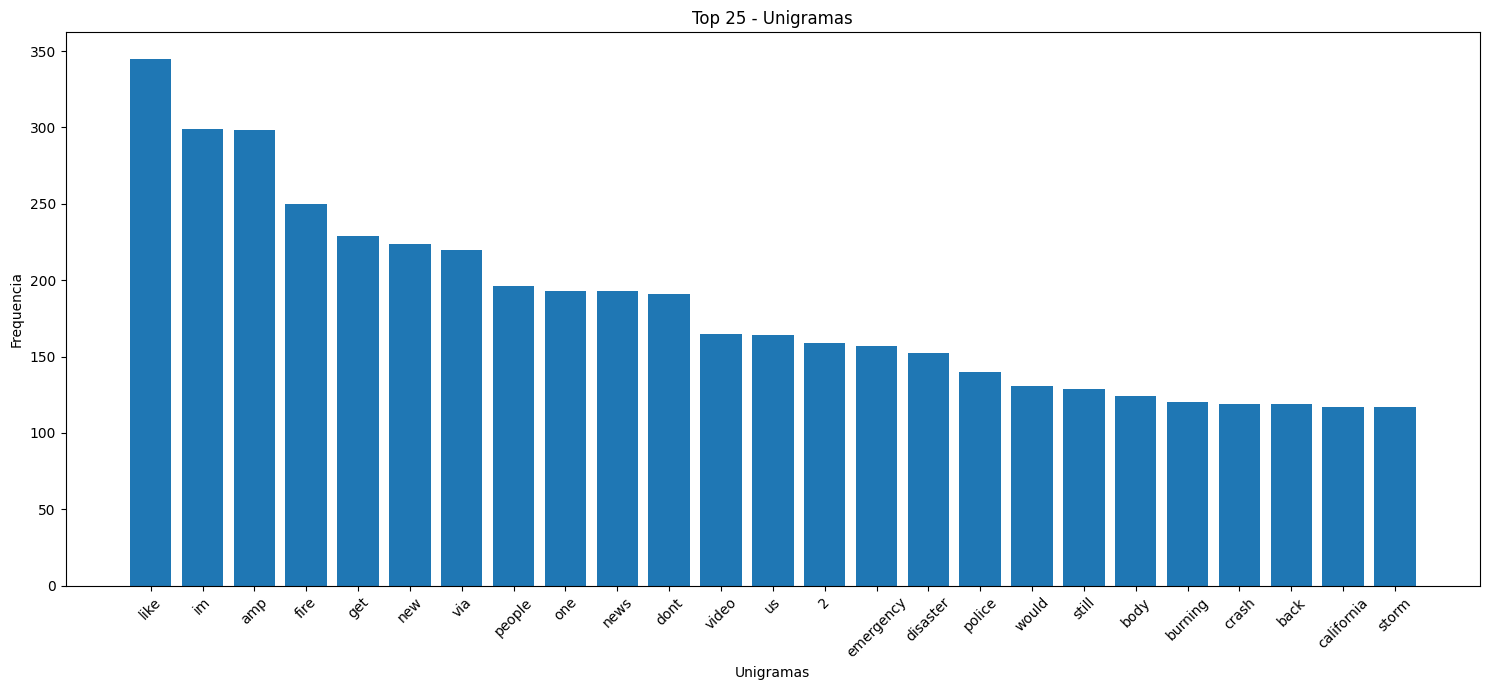

In [10]:
words_list = [word for sentence in df['text'] for word in sentence.split()]
unigram_freq = nltk.FreqDist(words_list)
# unigram_freq.plot(25)
top_bigrams = unigram_freq.most_common(25)

unigram_labels, freq = zip(*top_bigrams)
bigram_labels = [" ".join(bigram) for bigram in unigram_labels]

plt.figure(figsize=(15,7))
plt.bar(unigram_labels, freq)
plt.xticks(rotation=45)
plt.xlabel('Unigramas')
plt.ylabel('Frequencia')
plt.title('Top 25 - Unigramas')
plt.tight_layout()
plt.show()

Las palabras que más pueden servir para hacer un modelo de clasificación son: like, im, amp.

## 

In [11]:
unigram_probs = {k: v / len(words_list) for k, v in unigram_freq.items()}
unigram_probs = {k: v for k, v in sorted(unigram_probs.items(), key=lambda item: item[1], reverse=True)}
unigram_probs

{'like': 0.004517007515253083,
 'im': 0.003914739846552672,
 'amp': 0.0039016470711461418,
 'fire': 0.003273193851632669,
 'get': 0.0029982455680955247,
 'new': 0.0029327816910628716,
 'via': 0.002880410589436749,
 'people': 0.0025661839796800126,
 'one': 0.0025269056534604206,
 'news': 0.0025269056534604206,
 'dont': 0.002500720102647359,
 'video': 0.0021603079420775616,
 'us': 0.0021472151666710308,
 '2': 0.0020817512896383777,
 'emergency': 0.002055565738825316,
 'disaster': 0.0019901018617926626,
 'police': 0.0018329885569142947,
 'would': 0.0017151535782555186,
 'still': 0.0016889680274424573,
 'body': 0.001623504150409804,
 'burning': 0.0015711330487836813,
 'crash': 0.0015580402733771505,
 'back': 0.0015580402733771505,
 'california': 0.001531854722564089,
 'storm': 0.001531854722564089,
 'suicide': 0.0015187619471575585,
 'got': 0.0014663908455314358,
 'time': 0.0014663908455314358,
 'know': 0.0014663908455314358,
 'man': 0.0014402052947183744,
 'buildings': 0.00144020529471837

## Bigramas

/var/folders/wd/kpmqk46j1wq467f_h9w8l5440000gn/T/ipykernel_1386/2557472830.py:16: UserWarning: Glyph 137 (\x89) missing from current font.
  plt.tight_layout()
/Users/saramariapaguagagonzales/.pyenv/versions/3.11.3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


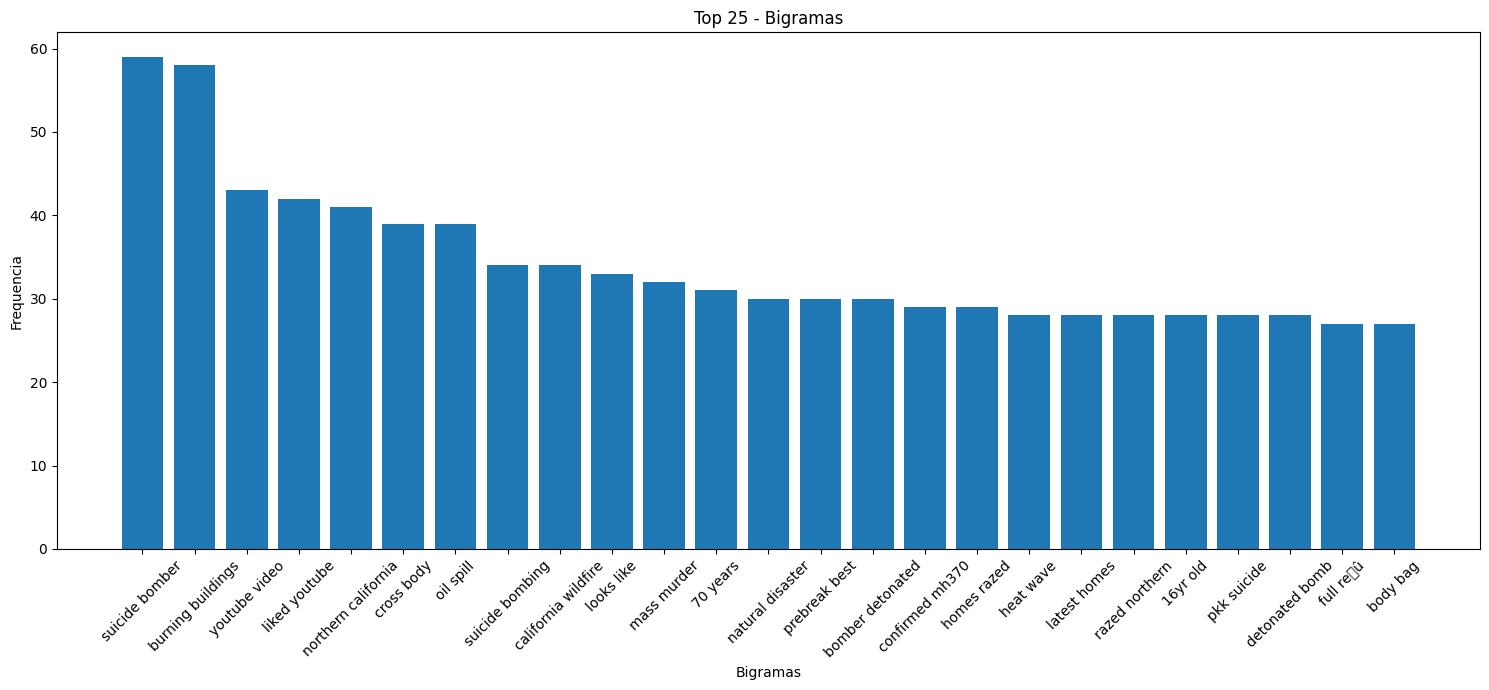

In [12]:
words_list_bigrams = [word for sentence in df['text'] for word in sentence.split()]
bigrams = list(nltk.bigrams(words_list_bigrams))
bigrams_freq = nltk.FreqDist(bigrams)

top_bigrams = bigrams_freq.most_common(25)

bigram_labels, freq = zip(*top_bigrams)
bigram_labels = [" ".join(bigram) for bigram in bigram_labels]

plt.figure(figsize=(15,7))
plt.bar(bigram_labels, freq)
plt.xticks(rotation=45)
plt.xlabel('Bigramas')
plt.ylabel('Frequencia')
plt.title('Top 25 - Bigramas')
plt.tight_layout()
plt.show()

In [13]:
bigrams_probs = {k: v / len(bigrams) for k, v in bigrams_freq.items()}
bigrams_probs = {k: v for k, v in sorted(bigrams_probs.items(), key=lambda item: item[1], reverse=True)}
bigrams_probs

{('suicide', 'bomber'): 0.0007724838629430326,
 ('burning', 'buildings'): 0.0007593909161134896,
 ('youtube', 'video'): 0.0005629967136703458,
 ('liked', 'youtube'): 0.0005499037668408029,
 ('northern', 'california'): 0.0005368108200112599,
 ('cross', 'body'): 0.0005106249263521741,
 ('oil', 'spill'): 0.0005106249263521741,
 ('suicide', 'bombing'): 0.00044516019220445943,
 ('california', 'wildfire'): 0.00044516019220445943,
 ('looks', 'like'): 0.0004320672453749165,
 ('mass', 'murder'): 0.0004189742985453736,
 ('70', 'years'): 0.0004058813517158307,
 ('natural', 'disaster'): 0.0003927884048862878,
 ('prebreak', 'best'): 0.0003927884048862878,
 ('bomber', 'detonated'): 0.0003927884048862878,
 ('confirmed', 'mh370'): 0.0003796954580567448,
 ('homes', 'razed'): 0.0003796954580567448,
 ('heat', 'wave'): 0.0003666025112272019,
 ('latest', 'homes'): 0.0003666025112272019,
 ('razed', 'northern'): 0.0003666025112272019,
 ('16yr', 'old'): 0.0003666025112272019,
 ('pkk', 'suicide'): 0.0003666025

## Algoritmo

Se utiliza Term Frequency Inverse Document Frecuency para poder transformar el texto en una representación numérica para poderlo utilizar en el algoritmo de predicción de regresión logistica y poder clasificar tweets pertenecen a la categoría de desastres o no.

In [14]:
vectorizer = TfidfVectorizer(max_features=800)
X = vectorizer.fit_transform(df['text'])
y = df['target'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.7745183887915937


In [15]:
tweet = "This is a tweet"

def classify_tweet(tweet_input):
    prediction = lr_model.predict(vectorizer.transform([tweet_input]))

    if prediction:
        return "This tweet belongs to the category of disasters."
    else:
        return "This tweet does not belong to the category of disasters."

classify_tweet(tweet)

'This tweet does not belong to the category of disasters.'

In [16]:
tweet2 = "This is catastrophic"
classify_tweet(tweet2)

'This tweet belongs to the category of disasters.'